In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gprob as gp

np.random.seed(0)

This notebook presents examples of maximum-likelihood fitting of a Gaussian process to observation data. The gradients required for the optimization of the likelihood are obtained in two ways: first via numeric differentiation using scipy, and second via automatic differentiation using jax and some auxiliary constructs.

For the parametric distributions set up using jax, the notebook also illustrates the calculation of information-geometric properties.

# The fitting target and the prior

As the first step, we define a target function to be fitted (a sum of several Fourier harmonics), and produce a data set of its "observations" consisting of the function values with added noise.

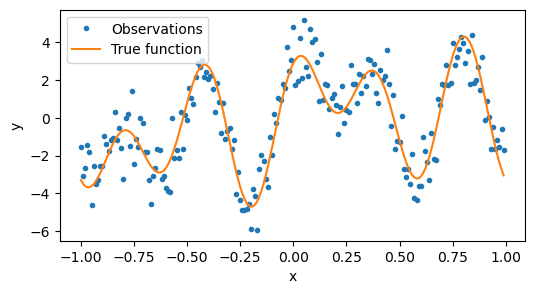

In [2]:
def y(x):  # the fitting target
    return -0.2 + np.sin(np.pi * x) + 2 * np.sin(3 * np.pi * x) + 0.6 * np.cos(np.pi * x) + 2.5 * np.cos(5 * np.pi * x)

n = 200  # the number of observations

xm = np.linspace(-1, 1, n, endpoint=False)
ym = y(xm) + np.random.normal(0, 1, size=n)  # the noisy observed values

_ = plt.figure(figsize=(6, 3))
plt.plot(xm, ym, marker=".", ls="None", label="Observations", color="tab:blue")
plt.plot(xm, y(xm), marker="None", ls="-", label="True function", color="tab:orange")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

The model for the data will be a periodic Gaussian process with the RBF correlation kernel plus white noise. To remind, the correlation function of the RBF kernel is
$$\langle y(x_1)y(x_2) \rangle=\exp\left(-(x_1-x_2)^2/\left(2\sigma^2\right)\right).$$

In [3]:
def convolve(x, y):
    """Convolves a normal random variable with a numeric array.
    
    Args:
        x: One-dimensional normal random variable.
        y: One-dimensional numeric array of the same size as ``x``.

    Returns:
        The convolved random variable of the same size as ``x``.
    """
    ftx = gp.fft.rfft(x)
    fty = np.fft.rfft(y)
    return gp.fft.irfft(ftx * fty)


def process(sigma, n):
    """Constructs a periodic Gaussian process with the correlation function
    `<x1 * x2> = Exp(-(x1-x2)^2 / (2 * sigma^2))`
    """
    x = gp.normal(size=n)
    y = np.exp(-np.linspace(-1, 1, n, endpoint=False)**2 / sigma**2)
    y = y / np.sqrt(np.sum(y**2))
    return convolve(x, y)


def model(u, v, sigma):
    """The model - a periodic Gaussian process with white observation noise. """
    return u * gp.normal(size=n) + v * process(sigma, n)

As an illustration, we can plot the log-scale correlation function of the process for some value of the correlation length $\sigma$.

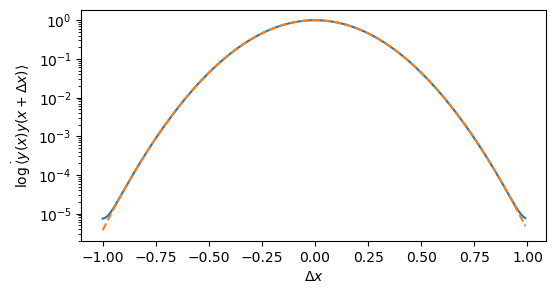

In [4]:
sigma = 0.2
g = process(sigma, n)

_ = plt.figure(figsize=(6, 3))
plt.plot(xm, gp.cov(g[n//2], g))
plt.plot(xm, np.exp(-xm**2/(2 * sigma**2)), linestyle="--")
plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$\log\.\langle y(x)y(x+\Delta x)\rangle$")
plt.yscale(r"log")

The starting point for the fitting will be

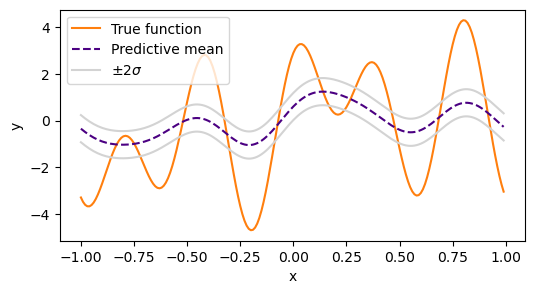

In [5]:
g = process(0.2, n)
gm = 3 * gp.normal(size=n) + 2 * g

gc = g | {gm: ym}

_ = plt.figure(figsize=(6, 3))
plt.plot(xm, y(xm), marker="None", ls="-", label="True function", color="tab:orange")
plt.plot(xm, gc.mean(), marker="None", ls="--", label="Predictive mean", color="indigo")
plt.plot(xm, gc.mean() + 2 * np.sqrt(gc.var()), marker="None", ls="-", label=r"$\pm 2\sigma$", color="lightgray")
plt.plot(xm, gc.mean() - 2 * np.sqrt(gc.var()), marker="None", ls="-", color="lightgray")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

# Fitting using scipy

Having set up the model, we can optimize the parameters of the Gaussian process by maximizing the likelihood of the observed data. Here, we do this using numerically computed gradients,

In [6]:
from time import time
from scipy.optimize import minimize


def cross_entropy(args):
    m = model(*args)
    return -m.logp(ym)


p0 = (3, 2, 0.2)  # the initial point

t0 = time()
min_sol1 = minimize(cross_entropy, p0)
print(f"Solution time: {time() - t0:.3g} s")
print(f"logp: {-min_sol1['fun']}")
print(f"Optimum parameters: {min_sol1['x']}")

Solution time: 0.404 s
logp: -313.0256837914127
Optimum parameters: [ 0.97638801  3.26445938 -0.13130832]


Plotting the optimum solution, we get

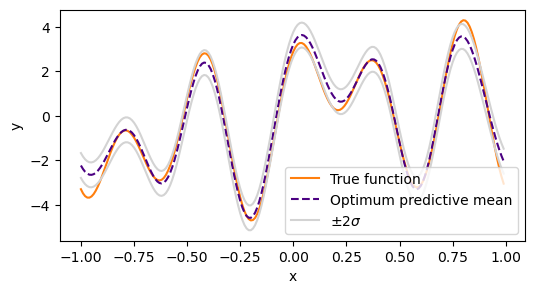

In [7]:
p_opt = min_sol1["x"]

g_opt = p_opt[1] * process(p_opt[2], n)
m_opt = p_opt[0] * gp.normal(size=n) + g_opt
g_opt_c = g_opt | {m_opt: ym}

_ = plt.figure(figsize=(6, 3))
plt.plot(xm, y(xm), marker="None", ls="-", label="True function", color="tab:orange")
plt.plot(xm, g_opt_c.mean(), marker="None", ls="--", label="Optimum predictive mean", color="indigo")
plt.plot(xm, g_opt_c.mean() + 2 * np.sqrt(g_opt_c.var()), marker="None", ls="-", label=r"$\pm 2\sigma$", color="lightgray")
plt.plot(xm, g_opt_c.mean() - 2 * np.sqrt(g_opt_c.var()), marker="None", ls="-", color="lightgray")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

For predicting the process values at $x$ outside of the measurement points, we can up-sample the $x$ grid. (The grid must remain equally spaced because of the way how we construct the process.)

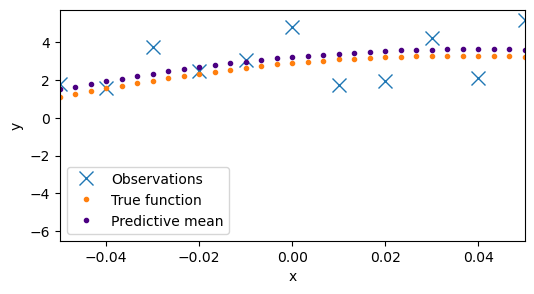

In [8]:
n_test = 3 * n
xt = np.linspace(-1, 1, n_test, endpoint=False)

g_opt = p_opt[1] * process(p_opt[2], n_test)
m_opt = p_opt[0] * gp.normal(size=n_test) + g_opt
g_opt_c = g_opt | {m_opt[::(n_test//n)]: ym}

_ = plt.figure(figsize=(6, 3))
plt.plot(xm, ym, marker="x", ms=10, ls="None", label="Observations", color="tab:blue")
plt.plot(xt, y(xt), marker=".", ls="None", label="True function", color="tab:orange")
plt.plot(xt, g_opt_c.mean(), marker=".", ls="None", label="Predictive mean", color="indigo")
plt.xlim(-0.05, 0.05)
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

# Automatic differentiation using jax

In [9]:
import jax
from jax import numpy as jnp

jax.config.update("jax_enable_x64", True)  # Double precision for automatic differentiation.

Next, we will use jax to for obtaining the gradients. In gprob, there is no built-in way of handling automatic differentiation, so some helper constructs need to be set up first. `ParametricNormal` will represent a parametric distribution, and `pnormal` will be a factory function that creates parametric distributions from jax functions, defined such that they operate on random samples given as explicit inputs.   

In [10]:
def jmp(fun, primals, tangents):
    """Forward mode jacobain-matrix product for ``fun``. Spans over the 0-th 
    dimension of each of the arrays in ``tangents``, and stacks the results 
    the along the 0-th dimension of the output.
    
    Args:
        primals: A list or tuple of positional arguments to ``fun`` at which its 
            Jacobian should be evaluated.
        tangents: A list or tuple of arrays of positional tangent vectors with
            the same structure as primals, and each array shape being augmented 
            by one outer-most dimension compared to primals.

    Returns:
        Jacobian-matrix product.
    """

    # The function calculates m_out = J @ m.T
    # It can handle multiple arguments, but otherwise is the same as in
    # https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html

    jvp = lambda t: jax.jvp(fun, primals, t)[1]
    return jax.vmap(jvp, in_axes=0, out_axes=0)(tangents)


def pnormal(f, input_vs, jit=True):
    """Creates a parametric normal random variable from a function with 
    the signature ``f(p, vs) -> u``, where ``u`` is an output array, 
    ``p`` is a 1D array of parameters, and ``vs`` is a sequence of numeric 
    arrays representing the realizations of input random variables.
    
    Args:
        f (callable): 
            The generating function.
        input_vs (sequence of normal varaibles): 
            The input normal variables whose values can be used as ``vs`` 
            in ``f(p, vs)``.
        jit (bool): 
            If `jax.jit` should be applied to the intermediate functions.

    Returns:
        Callable: a parametric normal variable representing the random function 
        ``lambda p: f(p, input_vs)``.
    """

    def force_float(x):
        return x if not np.issubdtype(x.dtype, int) else x.astype(np.float64)

    inbs = tuple(force_float(v.b) for v in input_vs)
    lat, inas = gp.maps.complete(input_vs)

    afun = lambda p: jmp(lambda *v: f(p, v), inbs, tuple(inas))
    bfun = lambda p: f(p, inbs)

    dafun = lambda p: jmp(afun, (jnp.array(p),), (jnp.eye(len(p)),))
    dbfun = lambda p: jmp(bfun, (jnp.array(p),), (jnp.eye(len(p)),))

    # Note: above, the conversion of ``p`` to jnp array is necessary when  
    # calculating the derivatives over ``p``, as the values of ``p`` will 
    # be input by the user, and the behavior of jax.jvp is sensitive to 
    # the data type. In contrast, in ``afun`` the inputs to jax.jvp are 
    # already always arrays.

    if jit:
        afun = jax.jit(afun)
        dafun = jax.jit(dafun)
        bfun = jax.jit(bfun)
        dbfun = jax.jit(dbfun)

    return ParametricNormal(afun, bfun, dafun, dbfun, lat)
    

class ParametricNormal:
    """Parametric normal random variable produced by a linearized function."""

    def __init__(self, afun, bfun, dafun, dbfun, lat):
        # The input functions produce jax arrays, which have to be 
        # converted to numpy arrays for further calculations.

        # ijk... is the array index of the variable, nlat is the number 
        # of the latent variables, np is the number of the parameters.

        self.a = lambda p: np.array(afun(p))    # shape:    nlat x ijk... 
        self.da = lambda p: np.array(dafun(p))  # shape:    np x nlat x ijk... 
        self.b = lambda p: np.array(bfun(p))    # shape:    ijk...
        self.db = lambda p: np.array(dbfun(p))  # shape:    np x ijk...

        self.lat = lat

    def __call__(self, p):
        return gp.Normal(self.a(p), self.b(p), self.lat)

    def _d01(self, p):
        """Mean vector and covariance matrix with their derivatives.

        Args:
            p: the vector of parameter values.
        
        Returns:
            (m, dm/dp, cov, dcov/dp), all flattened and converted to real.    
        """

        m = self.b(p).ravel()
        dm = self.db(p).reshape((-1, len(m)))
        a = self.a(p).reshape((len(self.lat), -1))
        da = self.da(p).reshape((-1,) + a.shape)

        cov = a.T @ a
        prod1 = a.T @ da
        dcov = prod1 + prod1.transpose(0, 2, 1)

        return m, dm, cov, dcov

    def logp(self, p, x):
        """Log probability density of a single sample."""

        x = np.asanyarray(x).ravel()
        m = self.b(p).ravel()
        a = self.a(p).reshape((len(self.lat), -1))
        cov = a.T @ a 
        
        return gp.func.logp(x, m, cov)

    def dlogp(self, p, x):
        """The gradient of the log probability density."""

        x = np.asanyarray(x).ravel()
        m, dm, cov, dcov = self._d01(p)
        
        return gp.func.dlogp(x, m, cov, dm, dcov)
    
    def fisher(self, p):
        """Fisher information matrix."""
        _, dm, cov, dcov = self._d01(p)
        return gp.func.fisher(cov, dm, dcov)
    
    def natdlogp(self, p, x):
        """Natural gradient."""
        
        x = np.asanyarray(x).ravel()
        m, dm, cov, dcov = self._d01(p)
        g = gp.func.dlogp(x, m, cov, dm, dcov)
        fimat = gp.func.fisher(cov, dm, dcov)

        return np.linalg.solve(fimat, g)

After the groundwork has been laid, defining a differentiable parametric Gaussian process looks like this

In [11]:
def jconvolve(x, y):
    ftx = jnp.fft.rfft(x)
    fty = jnp.fft.rfft(y)
    return jnp.fft.irfft(ftx * fty)


# The process and the model now have to take as explicit inputs lists of 
# realizations of the random variables, called here ``vs``.


def jprocess(sigma, vs):
    x, = vs
    y = jnp.exp(-jnp.linspace(-1, 1, len(x), endpoint=False)**2 / sigma**2)
    y = y / jnp.sqrt(jnp.sum(y**2))
    return jconvolve(x, y)


def jmodel(p, vs):
    u, v, sigma = p
    v1, v2 = vs
    return u * v1 + v * jprocess(sigma, [v2])


mod = pnormal(jmodel, [gp.normal(size=n), gp.normal(size=n)])

Parametric variables called with vectors of parameters produce normal variables. E.g., `mod(p)` gives a variable identical to the one produced by `model(*p)`, 

In [12]:
print(np.allclose(mod(p0).mean(), model(*p0).mean()))
print(np.allclose(mod(p0).var(), model(*p0).var()))

True
True


Additionally, parametric variables define the gradient of the log likelihood (found here via forward-mode automatic differentiation),

In [13]:
mod.dlogp(p0, ym)

array([ -41.65675819,    3.56249167, -173.1316187 ])

and the Fisher information matrix,

In [14]:
mod.fisher(p0)

array([[ 42.45501803,   0.47013334, -10.2147179 ],
       [  0.47013334,   3.0658094 , -12.51799019],
       [-10.2147179 , -12.51799019, 334.51978643]])

# Fitting using scipy with gradients

Now, after having set up a differential model, we can repeat the likelihood fit using scipy, this time also supplying the gradients to help the optimization

In [15]:
def cross_entropy_(args):
    f = -mod.logp(args, ym)
    g = -mod.dlogp(args, ym) 
    return (f, g)

t0 = time()
min_sol2 = minimize(cross_entropy_, (3, 2, 0.1), jac=True)
print(f"Solution time: {time() - t0:.3g} s")
print(f"logp: {-min_sol2['fun']}")
print(f"Optimum parameters: {min_sol2['x']}")

Solution time: 0.939 s
logp: -313.0256837914078
Optimum parameters: [0.97638802 3.26445658 0.13130827]


# Natural gradient descent and Fisher Information

Last, we implement natural gradient descent - an optimization algorithm that exploits information geometry to speed up the optimization convergence. Natural gradient $g_\mathrm{nat}$ is defined as the usual gradient multiplied by the inverse Fisher information matrix $F$, which sets a metric in the parameter space, 
$$g_\mathrm{nat}=F^{-1}\nabla_{p} \mathrm{logp},$$
where $p$ is the parameter vector. 

Our gaussian process fitting can be done using natural gradient descent as follows

In [16]:
p0 = (3, 2, 0.2)  # initial parameters

nitermax = 100
lr0 = 1

lr = lr0  # current learning rate
p = p0  # current parameters
t0 = time()
logp_prev = mod.logp(p, ym)
completed = False

for i in range(nitermax):
    g = mod.natdlogp(p, ym)

    while True:
        logp_new = mod.logp(p + lr * g, ym)

        if logp_prev < logp_new:
            p += lr * g  # accepts the step
            break
        elif abs((logp_prev - logp_new)/logp_prev) < 1e-16:
            completed = True
            break
        else:
            lr = lr / 2  # adapts the learning rate

    if completed: 
        break

    logp_prev = logp_new
    lr = lr0

print(f"Solution time: {time() - t0:.3g} s")
print(f"Final learning rate: {lr}, nit: {i+1}, logp: {logp_new}")

Solution time: 0.559 s
Final learning rate: 1, nit: 25, logp: -313.0256837914083
